# Part - 1: Automatic Images Color Labelling

*Yilin Lyu*

*yl3832@columbia.edu*

This jupyter notebook describes the automatic labeling process of labelling the image in the **Colors-Grid view.csv**


### This work was done by:

1) **Scrap and download** all the images from the Internet.
    
2) Label the images

To be labeled: **Brightness, Contrast, Color, Field, Genre**
   
       2.1) Label Brightness and contrast
            2.1.1) Example
       2.2) Use K-Means to find the dominant colors in images as the labels for color
            2.2.1) Example
       2.3) Use image segmentation to find the field
            Field here is defined as the ratio the genre to background
            2.3.1) Example
       2.4) Use KNN to find the genre of the picture
            2.4.1) Example
       2.5) Two full examples of the labelling process

3) **Save** the labels to csv file.

       3.1) Label all the images in the dataset
4) Visualizations of the results
       
       4.1) Word cloud
       4.2) Barplot of top colors
       4.3) Barplot of top genre
       4.4) Pie Charts of the brightness and contrast
              
There are **1285** new labels created in the **color** dataset. 

In [ ]:
# Output cleared
import pandas as pd
from PIL import Image,ImageStat,ImageEnhance
import requests
from io import BytesIO
import numpy as np
import os
from collections import namedtuple
from math import sqrt
import random
import webcolors
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from __future__ import division
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import collections
import cv2
import math

In [7]:
data = pd.read_csv("Colors-Grid view.csv")
data.head()

,Color_Name_,Color_Code,IMAGE,TAG: Color,id
0,Cut Paper,CUTPYS,SCzyoVwFSVqHCDkZXVYt_Cut%20Paper.png (https://...,"Primary Purple, Secondary Red, Field Large, Co...",rec0016dbT64i8wpT
1,White w/Thin Navy Vertical Stripe,WHITUI,fcsx6bXR7CHzNK8gtpPI_Screen%20Shot%202018-08-2...,NaN,rec01n5wINvMeGI9S
2,NF Maryam Poem 4x4 White G with Black Geometri...,NFMAQN,2GCO6HTRTcGkfUdou23J_Screen%20Shot%202018-09-2...,NaN,rec02wifpjC5YaQw7
3,Dancing Dots,BLACQF,Wf2e7HkURgSIXhF20UVV_Screen%20Shot%202017-12-0...,"Primary Black, Secondary Red, Field Medium, Co...",rec04jxWs5gMWnPbW
4,GUSSET FRANAY,GUSSXZ,yg3bcdkVR8yhOqmFfj7O_GUSSET%20FRANAY.JPG (http...,NaN,rec06AEMdH2s7n6Zm


## 1 ) Download all the images from the Internet 

In [2]:
def get_image_color(data_path, get_training = True):
    '''
    This function download all the image from the database to local machine
    It will extract url information from the table and download corresponding images with id as name
    '''
    data = pd.read_csv(data_path)
    image = data['IMAGE']
    type_list = ['png','jpg','JPG','JPEG','PNG']
    if get_training:
        image = image[-data['TAG: Color'].isnull()]
        image = image[-image.isna()]
        ids = data['id'][image.index]
        if not os.path.exists('color_train'):
            os.makedirs('color_train')
        for s,name in zip(image,ids):
            file_name = name + '.png'
            save_path = os.path.join('color_train',file_name)
            if file_name in os.listdir('color_train'):
                continue
            url = s[s.find("http"):len(s)-1]
            if url[-3:] not in type_list:
                continue
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.convert('RGB').save(os.path.join(save_path))
        print str(len(os.listdir('color_train'))) + ' labeled samples downloaded'
    if not get_training:
        image = image[data['TAG: Color'].isnull()]
        image = image[-image.isna()]
        ids = data['id'][image.index]
        if not os.path.exists('color_test'):
            os.makedirs('color_test')
        for s,name in zip(image,ids):
            file_name = name + '.png'
            save_path = os.path.join('color_test',file_name)
            if file_name in os.listdir('color_test'):
                continue
            url = s[s.find("http"):len(s)-1]
            if url[-3:] not in type_list:
                continue
            response = requests.get(url)
            img = Image.open(BytesIO(response.content))
            img.convert('RGB').save(save_path)
        print str(len(os.listdir('color_test'))) + ' unlabeled samples downloaded'
data_path = "Colors-Grid view.csv" 
get_image_color(data_path,True)
get_image_color(data_path,False)

639 labeled samples downloaded
1286 unlabeled samples downloaded


## 2) Label the images
Tode labeled: **Brightness, Contrast, Color, Gener**
   

### 2.1) Label Brightness and Contrast
            

In [29]:
image = cv2.imread('test1.png')
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
height, width, channels = hsv.shape

In [3]:
def calculate_brightness(image_path):
    '''
    This function calculate the brightness of the image and return a "Low","Medium","High"
    Reserence : https://gist.github.com/kmohrf/8d4653536aaa88965a69a06b81bcb022
    '''
    image = Image.open(image_path)
    greyscale_image = image.convert('L')
    histogram = greyscale_image.histogram()
    pixels = sum(histogram)
    brightness = scale = len(histogram)

    for index in range(0, scale):
        ratio = histogram[index] / pixels
        brightness += ratio * (-scale + index)
    if brightness == 255:
        brightness = 1
    else: brightness = brightness / scale
    
    if brightness<0.33:
        return "Low"
    if brightness>0.67:
        return "High"
    else: 
        return "Medium"
def calculate_contrast(image_path):
    '''
    Reference: https://en.wikipedia.org/wiki/Contrast_%28vision%29#RMS_contrast
    '''
    image = cv2.imread(image_path)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).flatten()/255
    img_gray = (img_gray - np.mean(img_gray))
    contrast = np.sqrt(np.mean(np.square(img_gray)))
    if contrast<0.33:
        return "Low"
    if contrast>0.67:
        return "High"
    else: 
        return "Medium"

#### 2.1.1) Example

Medium Brightness
Low Contrast


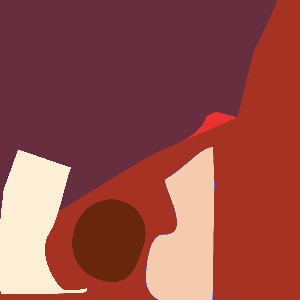

In [92]:
image_path = 'test1.png'
print calculate_brightness(image_path) + ' Brightness'
print calculate_contrast(image_path) + ' Contrast'
img = Image.open(image_path)
img.resize([300,300])

### 2.2) Use K-Means to find the dominant colors in images

In [4]:
Point = namedtuple('Point', ('coords', 'n', 'ct'))
Cluster = namedtuple('Cluster', ('points', 'center', 'n'))

def get_points(img):
    points = []
    w, h = img.size
    for count, color in img.getcolors(w * h):
        points.append(Point(color, 3, count))
    return points

#rtoh = lambda rgb: '#%s' % ''.join(('%02x' % p for p in rgb))

def colorz(filename, n=3):
    '''
    This function use K-Means algorithm to find the dominant colors in images.
    The input is the image and the output is the dominant colors in the images.
    Ref: http://charlesleifer.com/blog/using-python-and-k-means-to-find-the-dominant-colors-in-images/.
    Since not all kind of colors are well labeled: the function will output the closest labeled color instead.
    Ref: https://stackoverflow.com/questions/9694165/convert-rgb-color-to-english-color-name-like-green-with-python
    '''
    img = Image.open(filename)
    img.thumbnail((200, 200))
    w, h = img.size

    points = get_points(img)
    clusters = kmeans(points, n, 1)
    rgbs = [map(int, c.center.coords) for c in clusters]
    #return map(rtoh, rgbs)
    ans = []
    for rgb in rgbs:
        c = str(get_colour_name(rgb))
        if c not in ans:
            ans.append(c)
    return ans
    

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return  closest_name


def euclidean(p1, p2):
    return sqrt(sum([
        (p1.coords[i] - p2.coords[i]) ** 2 for i in range(p1.n)
    ]))

def calculate_center(points, n):
    vals = [0.0 for i in range(n)]
    plen = 0
    for p in points:
        plen += p.ct
        for i in range(n):
            vals[i] += (p.coords[i] * p.ct)
    return Point([(v / plen) for v in vals], n, 1)

def kmeans(points, k, min_diff):
    if len(points) < k:
        k = len(points)    
    clusters = [Cluster([p], p, p.n) for p in random.sample(points, k)]

    while 1:
        plists = [[] for i in range(k)]

        for p in points:
            smallest_distance = float('Inf')
            for i in range(k):
                distance = euclidean(p, clusters[i].center)
                if distance < smallest_distance:
                    smallest_distance = distance
                    idx = i
            plists[idx].append(p)

        diff = 0
        for i in range(k):
            old = clusters[i]
            center = calculate_center(plists[i], old.n)
            new = Cluster(plists[i], center, old.n)
            clusters[i] = new
            diff = max(diff, euclidean(old.center, new.center))

        if diff < min_diff:
            break

    return clusters
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)

def show_dominant(my_list):
    # Sort colors by hue, saturation, value and name.
    my_dict = dict()
    for name in my_list:
        my_dict[name] =colors[name]
    by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                    for name, color in my_dict.items())
    sorted_names = [name for hsv, name in by_hsv]

    n = len(sorted_names)
    ncols = 1
    nrows = n // ncols + 1

    fig, ax = plt.subplots(figsize=(3, 3))

    # Get height and width
    X, Y = fig.get_dpi() * fig.get_size_inches()
    h = Y / (nrows + 1)
    w = X / ncols

    for i, name in enumerate(sorted_names):
        col = i % ncols
        row = i // ncols
        y = Y - (row * h) - h

        xi_line = w * (col + 0.05)
        xf_line = w * (col + 0.25)
        xi_text = w * (col + 0.3)

        ax.text(xi_text, y, name, fontsize=(h * 0.8),
                horizontalalignment='left',
                verticalalignment='center')

        ax.hlines(y + h * 0.1, xi_line, xf_line,
                  color=colors[name], linewidth=(h * 0.6))

    ax.set_xlim(0, X)
    ax.set_ylim(0, Y)
    ax.set_axis_off()

    fig.subplots_adjust(left=0, right=1,
                        top=1, bottom=0,
                        hspace=0, wspace=0)
    plt.show()

#### 2.2.2) Examples

The followings are three examples of the detected dominant colors in images.

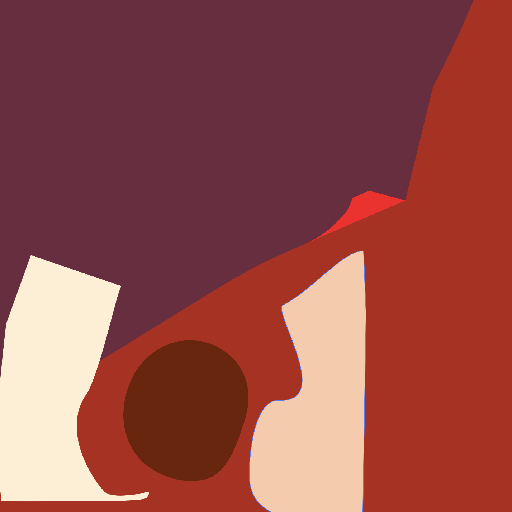

In [533]:
img = Image.open('test1.png')
img.resize([512,512])

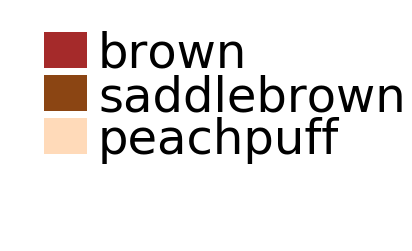

In [534]:
my_list = colorz('test1.png')
show_dominant(my_list)

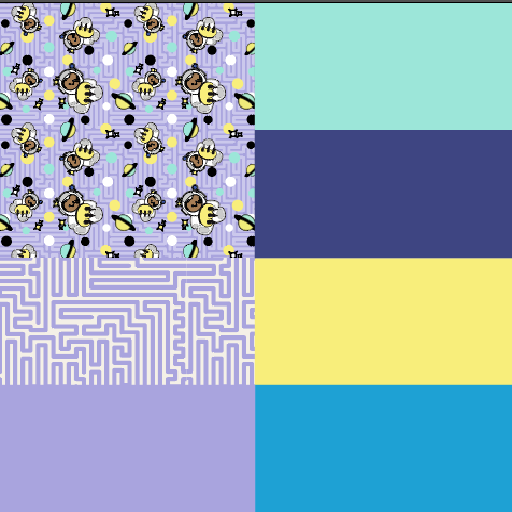

In [535]:
img = Image.open('test2.png')
img.resize([512,512])

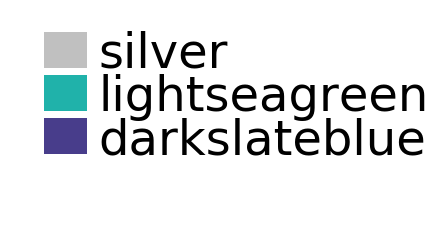

In [536]:
my_list = colorz('test2.png')
show_dominant(my_list)

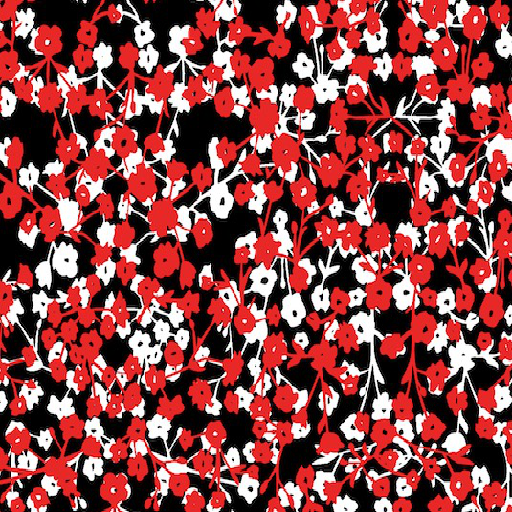

In [537]:
img = Image.open('test3.png')
img.resize([512,512])

In [538]:
my_list

['lightseagreen', 'darkslateblue', 'silver']

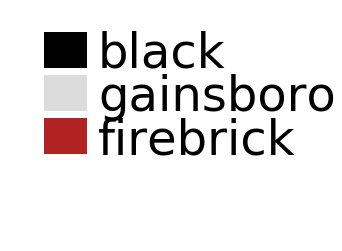

In [539]:
my_list = colorz('test3.png')
show_dominant(my_list)

### 2.3) Use image segmentation to find the field

In [8]:
def get_field(image_path):
    '''
    Reference https://docs.opencv.org/3.1.0/d3/db4/tutorial_py_watershed.html
    '''
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    unique, counts = np.unique(thresh, return_counts=True)
    ratio = counts[0]/np.sum(counts)
    ans = ''
    if ratio<0.1:
        ans = "Small"
    if ratio>0.4:
        ans = "Large"
    else: ans = "Medium"
    return thresh, ans 

#### 2.3.1) Example

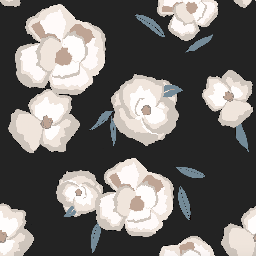

In [330]:
image_path = "test_1.png"
img = Image.open(image_path)
img.resize([256,256])

Large Field


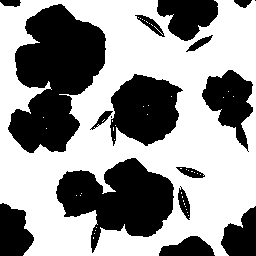

In [331]:
print get_field(image_path)[1] + " Field"
img = Image.fromarray(get_field(image_path)[0])
img.resize((256,256))

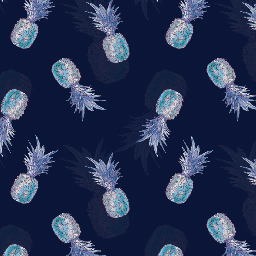

In [321]:
image_path = "test_2.png"
img = Image.open(image_path)
img.resize([256,256])

Medium Field


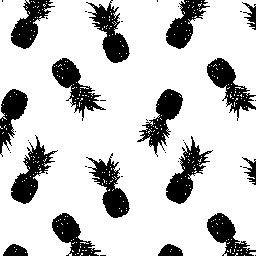

In [322]:
print get_field(image_path)[1] + " Field"
img = Image.fromarray(get_field(image_path)[0])
img.resize((256,256))

###  2.4) Use KNN to find the genre of the picture

In [10]:
'''
Create a list includes all the Genre type
'''
my_list = list(data['TAG: Color'][-data['TAG: Color'].isnull()])
s = ''
for row in my_list:
    if "Genre " in row or "genre "in row:
        sub_row = row[row.index("Genre "):]
        s = sub_row + ", " + s
    else: continue
my_list = s.split(", ")
for item in my_list[:]:
    if "Genre " not in item and "genre " not in row:
        my_list.remove(item)
gener_list = np.unique(my_list)
gener_list

array(['Genre Animal', 'Genre Animation', 'Genre Blocking',
       'Genre Cartoon', 'Genre Dark', 'Genre Floral', 'Genre Geometric',
       'Genre Happy', 'Genre Herringbone', 'Genre Jewel', 'Genre Nature',
       'Genre Nautical', 'Genre Photographic', 'Genre Plaid',
       'Genre Stripe', "Genre Trompe L'oeil", 'Genre Whimsy'],
      dtype='|S19')

In [11]:
'''
Create a list includes the training image for KNN
'''
def image_to_feature_vector(image_path, size=(128, 128)):
    '''
    This function convert image to vectors 
    '''
    # resize the image to a fixed size, then flatten the image into
    # a list of raw pixel intensities
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.resize(img_gray, size).flatten()
feature = []
ids = []
#tags = []
for image_name in os.listdir('color_train')[0:300]:
    image_path = os.path.join('color_train',image_name)
    i = image_name[:-4]
    ids.append(i)
    feature.append(image_to_feature_vector(image_path))

In [12]:
def euclideanDistance(instance1, instance2):
    '''
    This function calculate the distance between two images 
    '''
    distance = sum((instance1 - instance2)**2)
    return math.sqrt(distance)
def getNeighbors(trainingSet, testInstance, k = 3):
    '''
    This function returns the K cloest neighbors of the target unlabeled image
    '''
    distances = []
    neighbors = []
    length = len(testInstance)-1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x] )
        distances.append(dist)
    inds = np.argsort(distances)[6:k+6]
    for ind in inds:
        neighbors.append(ids[ind])
    return inds,neighbors
def get_genre(neighbors,gener_list = gener_list):
    '''
    This function labels the target image
    '''
    tag_list = []
    for neighbor in neighbors:
        tags = data[data['id']==neighbor]['TAG: Color']
        tag_list.extend(list(str(tags.iloc[0]).split(", ")))
    for tag in tag_list[:]:
        if tag in gener_list:
            continue
        else: tag_list.remove(tag)
    tag_counter = collections.Counter(tag_list)
    top_tags_list = tag_counter.most_common(1)
    ans = ''
    for tup in top_tags_list:
        ans = ans + tup[0] 
    return ans

#### 2.4.1) Example

Genre Floral


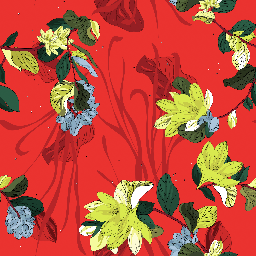

In [543]:
image = image_to_feature_vector('test_4.png')
inds, neighbors = getNeighbors(feature,image)
genre = get_genre(neighbors)
print genre
img = Image.open('test_4.png')
img.resize((256,256))

### 2.5) Two full examples of the labelling process

#### The results are pretty convincing

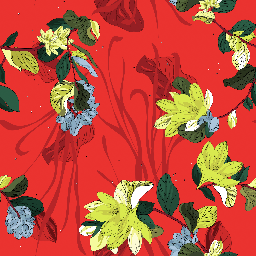

In [16]:
image_path = 'test_4.png'
img = Image.open(image_path)
img.resize((256,256))

Genre: Genre Floral
Field: Medium Field
Bright: Medium Brightness
Contrast: Low Contrast
Dominant Colors: 


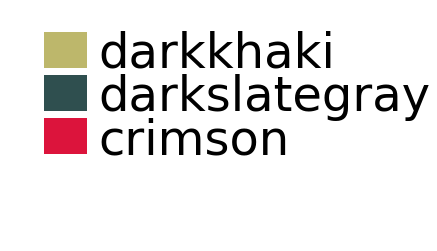

In [17]:
image = image_to_feature_vector(image_path)
inds, neighbors = getNeighbors(feature,image)
print "Genre: " + get_genre(neighbors) 
print "Field: " + get_field(image_path)[1] + " Field"
print "Bright: " + calculate_brightness(image_path) + ' Brightness'
print "Contrast: " + calculate_contrast(image_path) + ' Contrast'
print "Dominant Colors: " 
show_dominant(colorz(image_path))

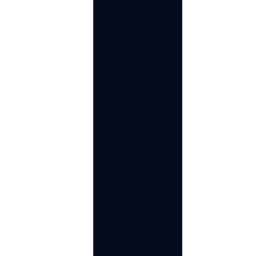

In [565]:
image_path = 'test_5.png'
img = Image.open(image_path)
img.resize((256,256))

Genre: Genre Stripe
Field: Large Field
Bright: Medium Brightness
Contrast: Medium Contrast


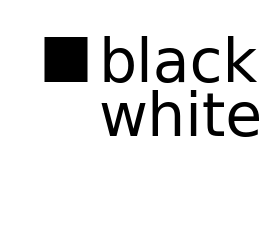

In [566]:
image = image_to_feature_vector(image_path)
inds, neighbors = getNeighbors(feature,image)
print "Genre: " + get_genre(neighbors) 
print "Field: " + get_field(image_path)[1] + " Field"
print "Bright: " + calculate_brightness(image_path) + ' Brightness'
print "Contrast: " + calculate_contrast(image_path) + ' Contrast'
show_dominant(colorz(image_path))

## 3) Now label all the images in the dataset

In [626]:
'''
Now label all iamges and save the table as a .csv file
'''
#data = pd.read_csv("Colors-Grid view.csv")
data = pd.read_csv('Colors-Grid_view_labeled.csv', index_col=0) #open when restore labelling
for image_name in os.listdir('color_test'):
    ind =  image_name[:-4]
    image_path = os.path.join('color_test', image_name)
    if image_path == 'color_test/.DS_Store':
        continue
    if len(str(data["TAG: Color"].iloc[data[data['id'] == ind].index[0]]))<4:
        colors = colorz(image_path,2)
        i = 0
        while i <len(colors):
            if i == 0 : 
                word = 'Primary '
            else: word = 'Secondary '
            colors[i] = word + colors[i]
            i = i + 1
        colors = str(colors)[1:-1]
        colors = colors.replace("'","")
        brightness = calculate_brightness(image_path)
        contrast = calculate_contrast(image_path)
        _,field = get_field(image_path)
        image = image_to_feature_vector(image_path)
        _, neighbors = getNeighbors(feature,image)
        genre = get_genre(neighbors)
        label = colors + ", " +' Bright ' + brightness  + ", " +' Contrast ' + contrast + ", Field " + field + ", " + genre
        data["TAG: Color"].iloc[data[data['id'] == ind].index[0]] = label
    else: pass
print 'all finished'

all finished


In [627]:
data.head()

,Color_Name_,Color_Code,IMAGE,TAG: Color,id
0,Cut Paper,CUTPYS,SCzyoVwFSVqHCDkZXVYt_Cut%20Paper.png (https://...,"Primary Purple, Secondary Red, Field Large, Co...",rec0016dbT64i8wpT
1,White w/Thin Navy Vertical Stripe,WHITUI,fcsx6bXR7CHzNK8gtpPI_Screen%20Shot%202018-08-2...,"Primary white, Secondary black, Bright Medium...",rec01n5wINvMeGI9S
2,NF Maryam Poem 4x4 White G with Black Geometri...,NFMAQN,2GCO6HTRTcGkfUdou23J_Screen%20Shot%202018-09-2...,"Primary dimgrey, Secondary whitesmoke, Bright...",rec02wifpjC5YaQw7
3,Dancing Dots,BLACQF,Wf2e7HkURgSIXhF20UVV_Screen%20Shot%202017-12-0...,"Primary Black, Secondary Red, Field Medium, Co...",rec04jxWs5gMWnPbW
4,GUSSET FRANAY,GUSSXZ,yg3bcdkVR8yhOqmFfj7O_GUSSET%20FRANAY.JPG (http...,"Primary snow, Secondary cadetblue, Bright Hig...",rec06AEMdH2s7n6Zm


In [628]:
data.tail()

,Color_Name_,Color_Code,IMAGE,TAG: Color,id
2031,The Worn Denim Plaid,WORNXO,O18sg8NTSeesVYmfs5V2_Screen%20Shot%202018-05-1...,"Primary lavender, Secondary slategray, Bright...",reczvqLtzVDLHFCik
2032,Thin Blush Stripe,BLUSXY,RYAZFtGEQcWurqpmvSnF_Screen%20Shot%202018-03-0...,"Primary gainsboro, Secondary burlywood, Brigh...",reczvxDadNSovrNvd
2033,NaN,NaN,NaN,NaN,reczwde2Tya2eElHG
2034,The Legend of Zelda Plaid,LGNDOV,cZwJIEBSTKam5WMm0f0c_Screen%20Shot%202017-07-0...,"Primary dimgrey, Secondary peru, Bright Mediu...",reczz5Wg1eq8306mN
2035,Honey,HONYSM,wsDfRvS0KD85KVtklT1w_Screen%20Shot%202018-11-0...,"Primary darksalmon, Secondary sandybrown, Bri...",reczzVV4C1h8MjWqw


In [729]:
data.to_csv("Colors-Grid_view_labeled.csv")

### 3.1) Label results

The whole dataset is labeled if there is a attached image of each sample and the labeled dataset is saved as **Colors-Grid_view_labeled.csv**.

There are **1285** new labels created in the **color** dataset. 

## 4) Visualizations of the results

In [714]:
my_list = list(data['TAG: Color'][-data['TAG: Color'].isnull()])
string = str(my_list)
string = string.replace("'","")
string = string.replace("/","")
string = string.replace("[","")
string = string.replace("]","")
string = string.replace(",","")
string = string.replace('"',"")
string = string.lower()

In [715]:
len(my_list)

1923

### 4.1) World cloud of the color tags

<Figure size 600x400 with 0 Axes>

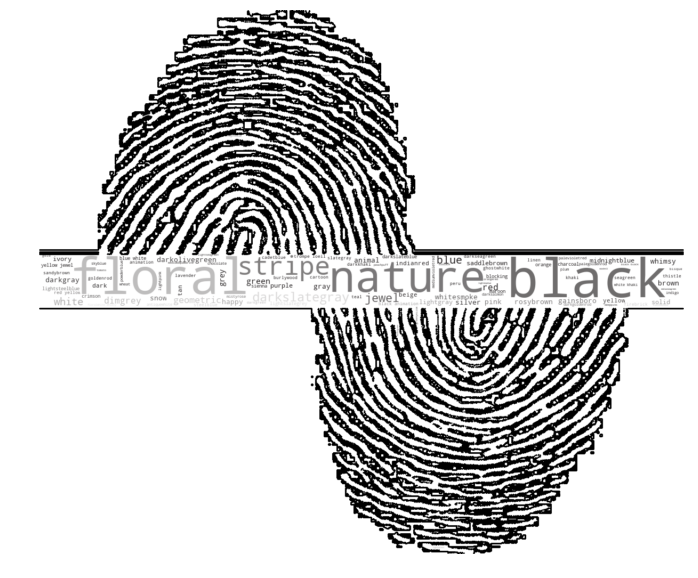

<Figure size 600x400 with 0 Axes>

In [654]:
mask = np.array(Image.open("rea_mask.png"))
stopwords = set(STOPWORDS)
stopwords.update(["medium","primary","genre","field","bright","contrast","secondary","high","low","plaid","large","small"])
wc = WordCloud(background_color="white", max_words=2000,stopwords = stopwords,
               mask=mask,contour_width=3, contour_color='black').generate(string)
image_colors = ImageColorGenerator(mask)
wc.recolor(color_func = image_colors).to_file("wc_rea.png")
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

<Figure size 600x400 with 0 Axes>

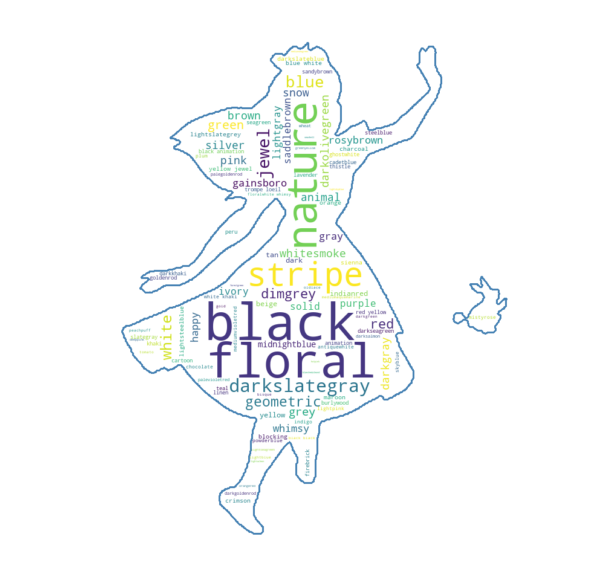

<Figure size 600x400 with 0 Axes>

In [656]:
mask = np.array(Image.open("alice_mask.png"))
stopwords = set(STOPWORDS)
stopwords.update(["medium","primary","genre","field","bright","contrast","secondary","high","low","plaid","large","small"])
wc = WordCloud(background_color="white", max_words=2000,stopwords = stopwords,
               mask=mask,contour_width=3, contour_color='steelblue').generate(string)
wc.to_file("wc_alice.png")
plt.figure(figsize=(20,10))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()

### 4.2) Barplot of top color

In [716]:
my_list = list(string.lower().split(' '))
counter=collections.Counter(my_list)
df = pd.DataFrame({'color':counter.keys(),'freq':counter.values()})
df = df.sort_values('freq',ascending = False)
not_list = ["medium","nature","animal","stripe","jewel","geometric","","primary","genre","field","bright","contrast","secondary","high","low","plaid","floral","large","small"]
for word in not_list:
    df = df[- (df['color'] == word)]
df.head(15)

,color,freq
13,black,423
112,darkslategray,258
40,blue,216
88,white,215
30,red,147
38,dimgrey,129
149,green,111
108,grey,98
122,whitesmoke,89
26,darkgray,85


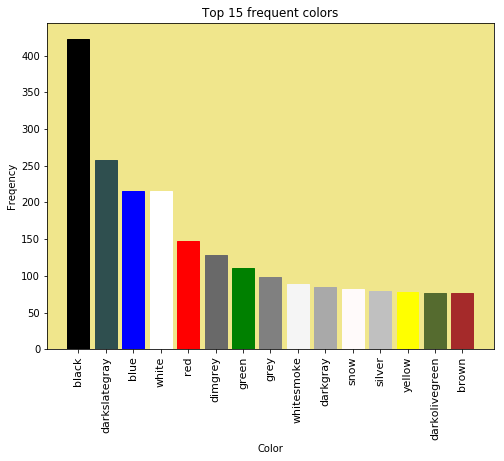

In [719]:
col = df.head(15)['color']
freq = df.head(15)['freq']
plt.figure(figsize=(8,6))
#plt.figure(figsize=(15,12))
index = np.arange(len(col))
barlist = plt.bar(index, freq)
for ind in range(15):
    barlist[ind].set_color(list(col)[ind])
ax = plt.gca()
ax.set_facecolor('khaki')
plt.xlabel('Color')
plt.ylabel('Freqency')
plt.xticks(index, col, fontsize = 11,rotation=90)
plt.title('Top 15 frequent colors')
#plt.savefig("barplot_color.png")
plt.show()

Above is a barplot of the labels, the top colors are showed and sorted by frequency.

#### 4.3) Barplot of top genre

In [720]:
my_list = list(data['TAG: Color'][-data['TAG: Color'].isnull()])
string = str(my_list)
string = string.replace("'","")
string = string.replace("/","")
string = string.replace("[","")
string = string.replace("]","")
string = string.replace('"',"")
my_list = list(string.split(", "))
for tag in my_list[:]:
    if tag in gener_list:
        continue
    else: my_list.remove(tag)
my_list
counter=collections.Counter(my_list)
df = pd.DataFrame({'Genre':counter.keys(),'freq':counter.values()})
df = df.sort_values('freq',ascending = False)
df.head(10)

,Genre,freq
2,Genre Floral,340
4,Genre Plaid,318
9,Genre Nature,260
11,Genre Stripe,258
15,Genre Jewel,249
13,Genre Geometric,141
1,Genre Animal,78
8,Genre Whimsy,75
7,Genre Happy,66
0,Genre Animation,37


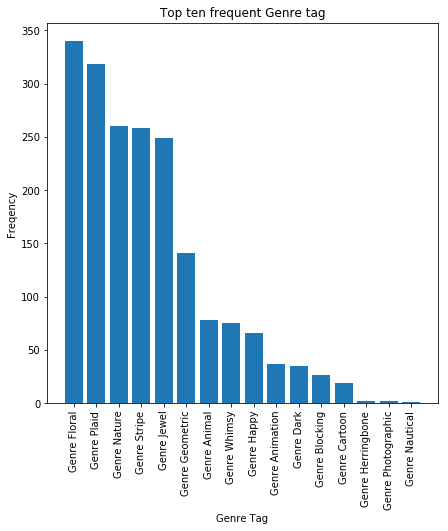

In [723]:
col = df.head(20)['Genre']
freq = df.head(20)['freq']

plt.figure(figsize=(7,7))
#plt.figure(figsize=(14,14))
index = np.arange(len(col))
plt.bar(index, freq)
ax = plt.gca()
plt.xlabel('Genre Tag')
plt.ylabel('Freqency')
plt.xticks(index, col, fontsize = 10,rotation=90)
plt.title('Top ten frequent Genre tag')
#plt.savefig("barplot_Genre.png")
plt.show()

#### 4.4) Pie Charts of the brightness and contrast

In [724]:
bright_list = ['Bright High', 'Bright Low', 'Bright Medium']
bright_list
contrast_list = ['Contrast High', 'Contrast Low', 'Contrast Medium']
contrast_list
my_list = list(string.split(", "))
for tag in my_list[:]:
    if tag in bright_list:
        continue
    else: my_list.remove(tag)
my_list
counter=collections.Counter(my_list)
df = pd.DataFrame({'Bright':counter.keys(),'freq':counter.values()})
df = df.sort_values('freq',ascending = False)
df.head(10)

,Bright,freq
2,Bright Medium,260
0,Bright Low,197
1,Bright High,156


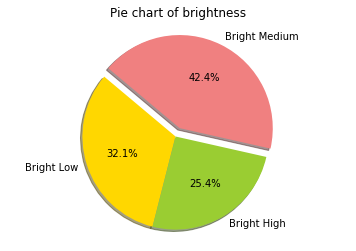

In [726]:
labels = counter.keys()
sizes = counter.values()
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0, 0, 0.1)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pie chart of brightness')
plt.axis('equal')
 
plt.show()

In [727]:
contrast_list = ['Contrast High', 'Contrast Low', 'Contrast Medium']
contrast_list
my_list = list(string.split(", "))
for tag in my_list[:]:
    if tag in contrast_list:
        continue
    else: my_list.remove(tag)
my_list
counter=collections.Counter(my_list)
df = pd.DataFrame({'Contrast':counter.keys(),'freq':counter.values()})
df = df.sort_values('freq',ascending = False)
df.head(10)

,Contrast,freq
1,Contrast Medium,214
2,Contrast High,207
0,Contrast Low,155


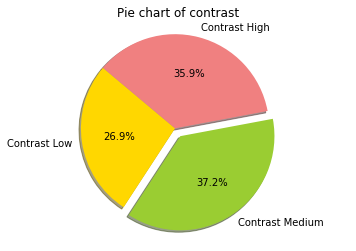

In [728]:
labels = counter.keys()
sizes = counter.values()
colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0, 0.1, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Pie chart of contrast')
plt.axis('equal')
plt.savefig("Pie_chart_contrast.png")
plt.show()

## Thank you!